In [1]:
import math
import random
import time
import torch
import torch.optim as optim

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from models import DQN, DuelingDQN, ReplayMemory, optimize_model

def select_action(state_in):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action_out = policy_net(state_in).max(1).indices.view(1, 1)
            return action_out
    else:
        return torch.tensor(spec.action_spec.random_action(1).discrete, device=device, dtype=torch.long)


In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

timer_start = time.perf_counter()
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 100_000
TAU = 0.005
LR = 1e-4

SAVE_WEIGHTS = True
LOAD_WEIGHTS = False
steps_done = 0
STEPS = 500
DOUBLE = True
DUELING = True
GRAPHICS = False

if torch.cuda.is_available():
    num_episodes = 10_000
else:
    num_episodes = 50

print("Number of episodes: ", num_episodes)
print(f"Double: {DOUBLE}, Dueling: {DUELING}")

Number of episodes:  10000
Double: True, Dueling: True


In [3]:

env = UnityEnvironment(file_name="unity_builds/snake", seed=13, side_channels=[], no_graphics=not GRAPHICS)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
# n_observations = len(state)
n_observations = spec.observation_specs[0].shape[0]

if DUELING:
    policy_net = DuelingDQN(n_observations, n_actions).to(device)
    target_net = DuelingDQN(n_observations, n_actions).to(device)
else:
    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)

if LOAD_WEIGHTS:
    policy_net.load_state_dict(torch.load('weights/policy_net.pth'))
    print("Loaded weights from file")

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000)
print(f"Initialized DQN with {n_observations} observations and {n_actions} actions")
rewards = []
losses = []

Initalized DQN with 8 observations and 4 actions


In [4]:
pbar = tqdm(range(num_episodes))
t = 0  # t init
for i_episode in pbar:
    if i_episode % 100 == 0 and i_episode != 0:
        print(
            f"Episode {i_episode}, avg reward: {np.mean(rewards[-100:]):.2f}, "
            f"epsilon: {EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY):.2f}")
        torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
        print("Checkpoint: Saved weights to file")
    step_rewards = []
    step_losses = []
    # Initialize the environment and get its state
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for t in range(STEPS):
        # time.sleep(1)
        action = select_action(state)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        assert action.shape[0] == state.shape[0]

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        reward = np.zeros(state.shape[0])
        if len(decision_steps.reward) > 0:
            reward += decision_steps.reward
        if len(terminal_steps.reward) > 0:
            reward += terminal_steps.reward
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0
        # print(observation, reward, done, terminated, action)
        assert len(reward) == state.shape[0] == action.shape[0]

        # if t % 50 == 0:
        #     print(f"step: {t}, reward: {reward}, state: {state}, action: {action}")
        reward = torch.tensor(reward, device=device)
        step_rewards.append(reward.item())


        if done or terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model(memory, policy_net, target_net, optimizer, device, double=DOUBLE, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA)
        if loss is not None:
            step_losses.append(loss)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if terminated or done:
            break
    
    if len(step_losses) == 0:
        step_losses.append(0)
    losses.append(np.mean(step_losses))
    ep_rewards = sum(step_rewards)
    pbar.set_description(f"E {i_episode} done after {t + 1} t, with r: {ep_rewards:.2f} and l: {np.mean(step_losses):.2f}")
    rewards.append(ep_rewards)

env.close()
print(f"Finished training in {(time.perf_counter() - timer_start)/3600} hours")


E 99 done after 4 t, with r: -1.00 and l: 0.00:   1%|          | 99/10000 [01:58<7:07:31,  2.59s/it]  

Episode 100, avg reward: -1.16, epsilon: 0.83
Checkpoint: Saved weights to file


E 199 done after 39 t, with r: -0.12 and l: 0.00:   2%|▏         | 200/10000 [03:57<3:52:40,  1.42s/it] 

Episode 200, avg reward: -1.12, epsilon: 0.77
Checkpoint: Saved weights to file


E 299 done after 159 t, with r: -1.62 and l: 0.01:   3%|▎         | 300/10000 [06:02<6:02:59,  2.25s/it]

Episode 300, avg reward: -1.04, epsilon: 0.71
Checkpoint: Saved weights to file


E 399 done after 329 t, with r: -1.28 and l: 0.01:   4%|▍         | 400/10000 [07:56<4:53:34,  1.83s/it]

Episode 400, avg reward: -1.06, epsilon: 0.66
Checkpoint: Saved weights to file


E 499 done after 137 t, with r: -0.51 and l: 0.01:   5%|▌         | 500/10000 [09:58<3:03:59,  1.16s/it]

Episode 500, avg reward: -1.01, epsilon: 0.61
Checkpoint: Saved weights to file


E 599 done after 111 t, with r: -0.41 and l: 0.01:   6%|▌         | 600/10000 [11:57<2:43:57,  1.05s/it]

Episode 600, avg reward: -0.98, epsilon: 0.57
Checkpoint: Saved weights to file


E 699 done after 12 t, with r: -1.03 and l: 0.01:   7%|▋         | 700/10000 [14:27<3:24:54,  1.32s/it] 

Episode 700, avg reward: -1.00, epsilon: 0.52
Checkpoint: Saved weights to file


E 799 done after 64 t, with r: -0.22 and l: 0.01:   8%|▊         | 800/10000 [16:31<3:39:16,  1.43s/it] 

Episode 800, avg reward: -0.89, epsilon: 0.48
Checkpoint: Saved weights to file


E 899 done after 76 t, with r: -1.29 and l: 0.02:   9%|▉         | 900/10000 [18:48<2:18:36,  1.09it/s] 

Episode 900, avg reward: -0.97, epsilon: 0.44
Checkpoint: Saved weights to file


E 999 done after 262 t, with r: -2.03 and l: 0.02:  10%|█         | 1000/10000 [21:05<5:51:42,  2.34s/it]

Episode 1000, avg reward: -0.90, epsilon: 0.41
Checkpoint: Saved weights to file


E 1099 done after 14 t, with r: -1.04 and l: 0.02:  11%|█         | 1100/10000 [23:14<1:22:19,  1.80it/s] 

Episode 1100, avg reward: -0.86, epsilon: 0.38
Checkpoint: Saved weights to file


E 1199 done after 244 t, with r: -0.94 and l: 0.02:  12%|█▏        | 1200/10000 [25:20<3:43:10,  1.52s/it]

Episode 1200, avg reward: -0.86, epsilon: 0.36
Checkpoint: Saved weights to file


E 1299 done after 354 t, with r: -0.36 and l: 0.01:  13%|█▎        | 1300/10000 [27:41<5:47:00,  2.39s/it]

Episode 1300, avg reward: -0.84, epsilon: 0.33
Checkpoint: Saved weights to file


E 1399 done after 171 t, with r: -0.65 and l: 0.01:  14%|█▍        | 1400/10000 [30:09<5:54:23,  2.47s/it]

Episode 1400, avg reward: -0.83, epsilon: 0.30
Checkpoint: Saved weights to file


E 1499 done after 139 t, with r: -1.54 and l: 0.02:  15%|█▌        | 1500/10000 [32:13<4:13:28,  1.79s/it]

Episode 1500, avg reward: -0.85, epsilon: 0.29
Checkpoint: Saved weights to file


E 1599 done after 136 t, with r: -0.51 and l: 0.02:  16%|█▌        | 1600/10000 [34:07<2:39:28,  1.14s/it]

Episode 1600, avg reward: -0.77, epsilon: 0.27
Checkpoint: Saved weights to file


E 1699 done after 6 t, with r: -1.01 and l: 0.03:  17%|█▋        | 1699/10000 [36:06<1:35:08,  1.45it/s]  

Episode 1700, avg reward: -0.79, epsilon: 0.26
Checkpoint: Saved weights to file


E 1799 done after 334 t, with r: -2.32 and l: 0.02:  18%|█▊        | 1800/10000 [38:22<4:15:10,  1.87s/it]

Episode 1800, avg reward: -0.72, epsilon: 0.24
Checkpoint: Saved weights to file


E 1899 done after 204 t, with r: -1.80 and l: 0.02:  19%|█▉        | 1900/10000 [41:06<4:06:27,  1.83s/it]

Episode 1900, avg reward: -0.94, epsilon: 0.22
Checkpoint: Saved weights to file


E 1999 done after 19 t, with r: -1.06 and l: 0.02:  20%|██        | 2000/10000 [43:12<1:33:28,  1.43it/s] 

Episode 2000, avg reward: -1.07, epsilon: 0.21
Checkpoint: Saved weights to file


E 2099 done after 244 t, with r: -0.94 and l: 0.01:  21%|██        | 2100/10000 [46:08<4:48:11,  2.19s/it]

Episode 2100, avg reward: -0.99, epsilon: 0.20
Checkpoint: Saved weights to file


E 2199 done after 47 t, with r: -1.17 and l: 0.02:  22%|██▏       | 2200/10000 [47:44<2:26:45,  1.13s/it] 

Episode 2200, avg reward: -0.58, epsilon: 0.19
Checkpoint: Saved weights to file


E 2299 done after 111 t, with r: -1.43 and l: 0.02:  23%|██▎       | 2300/10000 [50:10<2:32:40,  1.19s/it]

Episode 2300, avg reward: -0.60, epsilon: 0.18
Checkpoint: Saved weights to file


E 2399 done after 139 t, with r: -0.52 and l: 0.02:  24%|██▍       | 2400/10000 [52:29<3:01:38,  1.43s/it]

Episode 2400, avg reward: -0.67, epsilon: 0.17
Checkpoint: Saved weights to file


E 2499 done after 12 t, with r: -1.03 and l: 0.02:  25%|██▌       | 2500/10000 [54:39<2:42:30,  1.30s/it] 

Episode 2500, avg reward: -0.95, epsilon: 0.17
Checkpoint: Saved weights to file


E 2599 done after 246 t, with r: 1.09 and l: 0.02:  26%|██▌       | 2600/10000 [56:54<4:27:45,  2.17s/it] 

Episode 2600, avg reward: -0.64, epsilon: 0.16
Checkpoint: Saved weights to file


E 2699 done after 102 t, with r: -1.39 and l: 0.02:  27%|██▋       | 2700/10000 [59:13<1:50:13,  1.10it/s]

Episode 2700, avg reward: -0.89, epsilon: 0.15
Checkpoint: Saved weights to file


E 2799 done after 77 t, with r: -1.29 and l: 0.02:  28%|██▊       | 2800/10000 [1:01:36<3:48:35,  1.90s/it] 

Episode 2800, avg reward: -0.94, epsilon: 0.15
Checkpoint: Saved weights to file


E 2899 done after 24 t, with r: -1.08 and l: 0.02:  29%|██▉       | 2900/10000 [1:03:47<2:29:56,  1.27s/it] 

Episode 2900, avg reward: -0.86, epsilon: 0.14
Checkpoint: Saved weights to file


E 2999 done after 11 t, with r: -1.03 and l: 0.02:  30%|███       | 3000/10000 [1:06:16<1:48:45,  1.07it/s] 

Episode 3000, avg reward: -0.92, epsilon: 0.14
Checkpoint: Saved weights to file


E 3099 done after 31 t, with r: -1.11 and l: 0.02:  31%|███       | 3100/10000 [1:08:27<2:36:02,  1.36s/it] 

Episode 3100, avg reward: -0.96, epsilon: 0.13
Checkpoint: Saved weights to file


E 3199 done after 259 t, with r: 0.02 and l: 0.01:  32%|███▏      | 3200/10000 [1:10:46<2:39:16,  1.41s/it] 

Episode 3200, avg reward: -0.95, epsilon: 0.13
Checkpoint: Saved weights to file


E 3299 done after 176 t, with r: -1.69 and l: 0.02:  33%|███▎      | 3300/10000 [1:13:00<2:06:43,  1.13s/it]

Episode 3300, avg reward: -0.65, epsilon: 0.13
Checkpoint: Saved weights to file


E 3399 done after 2 t, with r: -0.99 and l: 0.01:  34%|███▍      | 3399/10000 [1:15:00<1:31:32,  1.20it/s]  

Episode 3400, avg reward: -0.92, epsilon: 0.13
Checkpoint: Saved weights to file


E 3499 done after 26 t, with r: -1.09 and l: 0.02:  35%|███▌      | 3500/10000 [1:16:58<57:30,  1.88it/s]   

Episode 3500, avg reward: -0.83, epsilon: 0.12
Checkpoint: Saved weights to file


E 3599 done after 299 t, with r: -1.16 and l: 0.01:  36%|███▌      | 3600/10000 [1:19:23<4:43:36,  2.66s/it]

Episode 3600, avg reward: -0.88, epsilon: 0.12
Checkpoint: Saved weights to file


E 3699 done after 26 t, with r: -1.09 and l: 0.01:  37%|███▋      | 3700/10000 [1:21:52<2:21:44,  1.35s/it] 

Episode 3700, avg reward: -0.82, epsilon: 0.12
Checkpoint: Saved weights to file


E 3799 done after 284 t, with r: -2.12 and l: 0.01:  38%|███▊      | 3800/10000 [1:24:40<4:39:02,  2.70s/it]

Episode 3800, avg reward: -1.00, epsilon: 0.12
Checkpoint: Saved weights to file


E 3900 done after 9 t, with r: -1.02 and l: 0.03:  39%|███▉      | 3901/10000 [1:27:03<1:10:32,  1.44it/s]  

Episode 3900, avg reward: -0.48, epsilon: 0.11
Checkpoint: Saved weights to file


E 3999 done after 71 t, with r: -1.27 and l: 0.01:  40%|████      | 4000/10000 [1:29:16<1:56:11,  1.16s/it] 

Episode 4000, avg reward: -0.67, epsilon: 0.11
Checkpoint: Saved weights to file


E 4099 done after 29 t, with r: -1.10 and l: 0.01:  41%|████      | 4100/10000 [1:31:34<3:24:36,  2.08s/it] 

Episode 4100, avg reward: -0.86, epsilon: 0.11
Checkpoint: Saved weights to file


E 4199 done after 111 t, with r: -0.41 and l: 0.01:  42%|████▏     | 4200/10000 [1:33:44<2:35:00,  1.60s/it]

Episode 4200, avg reward: -0.99, epsilon: 0.11
Checkpoint: Saved weights to file


E 4299 done after 24 t, with r: -1.08 and l: 0.01:  43%|████▎     | 4300/10000 [1:35:39<1:47:23,  1.13s/it] 

Episode 4300, avg reward: -0.92, epsilon: 0.11
Checkpoint: Saved weights to file


E 4399 done after 87 t, with r: -1.33 and l: 0.01:  44%|████▍     | 4400/10000 [1:38:37<2:39:57,  1.71s/it] 

Episode 4400, avg reward: -0.79, epsilon: 0.11
Checkpoint: Saved weights to file


E 4499 done after 104 t, with r: -1.40 and l: 0.02:  45%|████▌     | 4500/10000 [1:40:53<2:44:00,  1.79s/it]

Episode 4500, avg reward: -0.56, epsilon: 0.11
Checkpoint: Saved weights to file


E 4599 done after 179 t, with r: -0.68 and l: 0.01:  46%|████▌     | 4600/10000 [1:43:00<3:23:06,  2.26s/it]

Episode 4600, avg reward: -0.69, epsilon: 0.11
Checkpoint: Saved weights to file


E 4700 done after 6 t, with r: -1.01 and l: 0.03:  47%|████▋     | 4700/10000 [1:45:10<1:29:24,  1.01s/it]  

Episode 4700, avg reward: -0.52, epsilon: 0.11
Checkpoint: Saved weights to file


E 4799 done after 139 t, with r: -1.54 and l: 0.02:  48%|████▊     | 4800/10000 [1:47:16<1:42:43,  1.19s/it]

Episode 4800, avg reward: -0.23, epsilon: 0.11
Checkpoint: Saved weights to file


E 4899 done after 42 t, with r: -0.13 and l: 0.02:  49%|████▉     | 4900/10000 [1:49:26<1:42:43,  1.21s/it] 

Episode 4900, avg reward: -0.71, epsilon: 0.11
Checkpoint: Saved weights to file


E 4999 done after 24 t, with r: -1.08 and l: 0.01:  50%|█████     | 5000/10000 [1:51:56<2:07:57,  1.54s/it] 

Episode 5000, avg reward: -0.78, epsilon: 0.10
Checkpoint: Saved weights to file


E 5099 done after 34 t, with r: -1.12 and l: 0.02:  51%|█████     | 5100/10000 [1:54:25<52:35,  1.55it/s]   

Episode 5100, avg reward: -0.94, epsilon: 0.10
Checkpoint: Saved weights to file


E 5199 done after 41 t, with r: -1.15 and l: 0.03:  52%|█████▏    | 5200/10000 [1:56:34<2:06:57,  1.59s/it] 

Episode 5200, avg reward: -0.44, epsilon: 0.10
Checkpoint: Saved weights to file


E 5299 done after 77 t, with r: -1.29 and l: 0.03:  53%|█████▎    | 5300/10000 [1:58:24<1:18:06,  1.00it/s] 

Episode 5300, avg reward: -0.25, epsilon: 0.10
Checkpoint: Saved weights to file


E 5399 done after 162 t, with r: 0.41 and l: 0.02:  54%|█████▍    | 5400/10000 [2:00:40<1:52:59,  1.47s/it] 

Episode 5400, avg reward: -0.56, epsilon: 0.10
Checkpoint: Saved weights to file


E 5499 done after 4 t, with r: -1.00 and l: 0.02:  55%|█████▌    | 5500/10000 [2:03:13<28:30,  2.63it/s]    

Episode 5500, avg reward: -0.90, epsilon: 0.10
Checkpoint: Saved weights to file


E 5599 done after 7 t, with r: -1.01 and l: 0.01:  56%|█████▌    | 5600/10000 [2:05:12<59:36,  1.23it/s]    

Episode 5600, avg reward: -1.01, epsilon: 0.10
Checkpoint: Saved weights to file


E 5699 done after 94 t, with r: -1.36 and l: 0.02:  57%|█████▋    | 5700/10000 [2:07:26<47:05,  1.52it/s]   

Episode 5700, avg reward: -0.79, epsilon: 0.10
Checkpoint: Saved weights to file


E 5799 done after 214 t, with r: -1.84 and l: 0.02:  58%|█████▊    | 5800/10000 [2:10:03<1:41:45,  1.45s/it]

Episode 5800, avg reward: -0.77, epsilon: 0.10
Checkpoint: Saved weights to file


E 5899 done after 206 t, with r: 0.23 and l: 0.02:  59%|█████▉    | 5900/10000 [2:12:45<1:38:44,  1.44s/it] 

Episode 5900, avg reward: -0.17, epsilon: 0.10
Checkpoint: Saved weights to file


E 5999 done after 214 t, with r: 2.24 and l: 0.01:  60%|██████    | 6000/10000 [2:15:35<2:55:05,  2.63s/it] 

Episode 6000, avg reward: -0.36, epsilon: 0.10
Checkpoint: Saved weights to file


E 6099 done after 14 t, with r: -1.04 and l: 0.01:  61%|██████    | 6100/10000 [2:17:51<1:26:41,  1.33s/it] 

Episode 6100, avg reward: -0.79, epsilon: 0.10
Checkpoint: Saved weights to file


E 6199 done after 114 t, with r: -1.44 and l: 0.01:  62%|██████▏   | 6200/10000 [2:20:22<2:05:40,  1.98s/it]

Episode 6200, avg reward: -0.92, epsilon: 0.10
Checkpoint: Saved weights to file


E 6299 done after 82 t, with r: 0.73 and l: 0.02:  63%|██████▎   | 6300/10000 [2:22:34<1:05:03,  1.06s/it]  

Episode 6300, avg reward: -0.85, epsilon: 0.10
Checkpoint: Saved weights to file


E 6399 done after 131 t, with r: 0.53 and l: 0.02:  64%|██████▍   | 6400/10000 [2:24:42<1:16:30,  1.28s/it] 

Episode 6400, avg reward: -0.86, epsilon: 0.10
Checkpoint: Saved weights to file


E 6499 done after 69 t, with r: -1.26 and l: 0.02:  65%|██████▌   | 6500/10000 [2:27:02<35:52,  1.63it/s]   

Episode 6500, avg reward: -0.71, epsilon: 0.10
Checkpoint: Saved weights to file


E 6599 done after 206 t, with r: -1.81 and l: 0.02:  66%|██████▌   | 6600/10000 [2:29:08<1:13:16,  1.29s/it]

Episode 6600, avg reward: -0.68, epsilon: 0.10
Checkpoint: Saved weights to file


E 6701 done after 4 t, with r: -1.00 and l: 0.01:  67%|██████▋   | 6701/10000 [2:31:37<1:17:32,  1.41s/it]  

Episode 6700, avg reward: -0.95, epsilon: 0.10
Checkpoint: Saved weights to file


E 6799 done after 137 t, with r: -1.53 and l: 0.01:  68%|██████▊   | 6800/10000 [2:34:00<1:12:51,  1.37s/it]

Episode 6800, avg reward: -1.11, epsilon: 0.10
Checkpoint: Saved weights to file


E 6899 done after 104 t, with r: -1.40 and l: 0.01:  69%|██████▉   | 6900/10000 [2:36:11<48:03,  1.08it/s]  

Episode 6900, avg reward: -0.99, epsilon: 0.10
Checkpoint: Saved weights to file


E 6999 done after 82 t, with r: -1.31 and l: 0.01:  70%|███████   | 7000/10000 [2:39:21<1:54:49,  2.30s/it] 

Episode 7000, avg reward: -0.64, epsilon: 0.10
Checkpoint: Saved weights to file


E 7099 done after 39 t, with r: -1.14 and l: 0.01:  71%|███████   | 7100/10000 [2:41:45<48:43,  1.01s/it]   

Episode 7100, avg reward: -0.97, epsilon: 0.10
Checkpoint: Saved weights to file


E 7199 done after 24 t, with r: -0.06 and l: 0.01:  72%|███████▏  | 7200/10000 [2:43:51<46:33,  1.00it/s]   

Episode 7200, avg reward: -0.73, epsilon: 0.10
Checkpoint: Saved weights to file


E 7299 done after 47 t, with r: -1.17 and l: 0.01:  73%|███████▎  | 7300/10000 [2:46:19<1:23:44,  1.86s/it] 

Episode 7300, avg reward: -0.54, epsilon: 0.10
Checkpoint: Saved weights to file


E 7399 done after 12 t, with r: -1.03 and l: 0.01:  74%|███████▍  | 7400/10000 [2:48:32<33:52,  1.28it/s]   

Episode 7400, avg reward: -0.76, epsilon: 0.10
Checkpoint: Saved weights to file


E 7499 done after 90 t, with r: -1.34 and l: 0.01:  75%|███████▌  | 7500/10000 [2:51:19<1:32:21,  2.22s/it] 

Episode 7500, avg reward: -0.68, epsilon: 0.10
Checkpoint: Saved weights to file


E 7599 done after 226 t, with r: -0.87 and l: 0.02:  76%|███████▌  | 7600/10000 [2:53:13<50:12,  1.26s/it]  

Episode 7600, avg reward: -0.86, epsilon: 0.10
Checkpoint: Saved weights to file


E 7699 done after 49 t, with r: 0.86 and l: 0.02:  77%|███████▋  | 7700/10000 [2:55:33<1:01:55,  1.62s/it]  

Episode 7700, avg reward: -0.38, epsilon: 0.10
Checkpoint: Saved weights to file


E 7799 done after 269 t, with r: 2.02 and l: 0.02:  78%|███████▊  | 7800/10000 [2:58:11<1:20:24,  2.19s/it] 

Episode 7800, avg reward: -0.36, epsilon: 0.10
Checkpoint: Saved weights to file


E 7900 done after 14 t, with r: -1.04 and l: 0.02:  79%|███████▉  | 7900/10000 [3:00:32<41:55,  1.20s/it]   

Episode 7900, avg reward: -0.73, epsilon: 0.10
Checkpoint: Saved weights to file


E 7999 done after 61 t, with r: -1.23 and l: 0.01:  80%|████████  | 8000/10000 [3:02:46<39:13,  1.18s/it]   

Episode 8000, avg reward: -1.06, epsilon: 0.10
Checkpoint: Saved weights to file


E 8099 done after 171 t, with r: -1.67 and l: 0.02:  81%|████████  | 8100/10000 [3:05:33<1:05:07,  2.06s/it]

Episode 8100, avg reward: -0.80, epsilon: 0.10
Checkpoint: Saved weights to file


E 8199 done after 34 t, with r: -1.12 and l: 0.02:  82%|████████▏ | 8200/10000 [3:08:17<45:24,  1.51s/it]   

Episode 8200, avg reward: -0.87, epsilon: 0.10
Checkpoint: Saved weights to file


E 8299 done after 147 t, with r: -1.57 and l: 0.01:  83%|████████▎ | 8300/10000 [3:10:22<38:49,  1.37s/it]  

Episode 8300, avg reward: -0.76, epsilon: 0.10
Checkpoint: Saved weights to file


E 8399 done after 151 t, with r: -1.59 and l: 0.01:  84%|████████▍ | 8400/10000 [3:12:55<45:58,  1.72s/it]  

Episode 8400, avg reward: -0.83, epsilon: 0.10
Checkpoint: Saved weights to file


E 8499 done after 27 t, with r: -1.09 and l: 0.01:  85%|████████▌ | 8500/10000 [3:15:25<23:59,  1.04it/s]   

Episode 8500, avg reward: -0.70, epsilon: 0.10
Checkpoint: Saved weights to file


E 8599 done after 104 t, with r: -1.40 and l: 0.02:  86%|████████▌ | 8600/10000 [3:17:53<32:35,  1.40s/it]  

Episode 8600, avg reward: -0.65, epsilon: 0.10
Checkpoint: Saved weights to file


E 8699 done after 36 t, with r: -1.13 and l: 0.01:  87%|████████▋ | 8700/10000 [3:20:11<15:14,  1.42it/s]   

Episode 8700, avg reward: -0.75, epsilon: 0.10
Checkpoint: Saved weights to file


E 8799 done after 29 t, with r: -1.10 and l: 0.01:  88%|████████▊ | 8800/10000 [3:22:10<10:36,  1.88it/s] 

Episode 8800, avg reward: -0.85, epsilon: 0.10
Checkpoint: Saved weights to file


E 8899 done after 27 t, with r: -0.07 and l: 0.02:  89%|████████▉ | 8900/10000 [3:24:21<13:25,  1.37it/s] 

Episode 8900, avg reward: -0.30, epsilon: 0.10
Checkpoint: Saved weights to file


E 9000 done after 9 t, with r: -1.02 and l: 0.02:  90%|█████████ | 9001/10000 [3:26:41<26:27,  1.59s/it]  

Episode 9000, avg reward: -0.53, epsilon: 0.10
Checkpoint: Saved weights to file


E 9099 done after 19 t, with r: -1.06 and l: 0.01:  91%|█████████ | 9100/10000 [3:29:11<20:51,  1.39s/it] 

Episode 9100, avg reward: -0.56, epsilon: 0.10
Checkpoint: Saved weights to file


E 9199 done after 184 t, with r: 1.34 and l: 0.02:  92%|█████████▏| 9200/10000 [3:31:18<17:24,  1.31s/it] 

Episode 9200, avg reward: -0.96, epsilon: 0.10
Checkpoint: Saved weights to file


E 9299 done after 354 t, with r: -2.40 and l: 0.01:  93%|█████████▎| 9300/10000 [3:33:21<28:33,  2.45s/it]

Episode 9300, avg reward: -0.94, epsilon: 0.10
Checkpoint: Saved weights to file


E 9400 done after 1 t, with r: -0.99 and l: 0.02:  94%|█████████▍| 9400/10000 [3:35:52<09:49,  1.02it/s]  

Episode 9400, avg reward: -0.87, epsilon: 0.10
Checkpoint: Saved weights to file


E 9499 done after 77 t, with r: -1.29 and l: 0.01:  95%|█████████▌| 9500/10000 [3:37:59<13:51,  1.66s/it] 

Episode 9500, avg reward: -0.64, epsilon: 0.10
Checkpoint: Saved weights to file


E 9599 done after 51 t, with r: -1.19 and l: 0.02:  96%|█████████▌| 9600/10000 [3:40:15<05:02,  1.32it/s] 

Episode 9600, avg reward: -0.62, epsilon: 0.10
Checkpoint: Saved weights to file


E 9699 done after 77 t, with r: -1.29 and l: 0.02:  97%|█████████▋| 9700/10000 [3:42:56<05:33,  1.11s/it] 

Episode 9700, avg reward: -0.36, epsilon: 0.10
Checkpoint: Saved weights to file


E 9799 done after 14 t, with r: -1.04 and l: 0.01:  98%|█████████▊| 9800/10000 [3:45:35<04:53,  1.47s/it] 

Episode 9800, avg reward: -0.49, epsilon: 0.10
Checkpoint: Saved weights to file


E 9899 done after 79 t, with r: -0.28 and l: 0.02:  99%|█████████▉| 9900/10000 [3:47:24<01:53,  1.14s/it] 

Episode 9900, avg reward: -0.67, epsilon: 0.10
Checkpoint: Saved weights to file


E 9999 done after 172 t, with r: 0.37 and l: 0.01: 100%|██████████| 10000/10000 [3:49:33<00:00,  1.38s/it]

Finished training in 2.3e+02 minutes


In [7]:

if SAVE_WEIGHTS:
    torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
    rewards_df = pd.DataFrame(rewards, columns=['reward'])
    rewards_df.to_csv('rewards.csv', index=False)
    losses_df = pd.DataFrame(losses, columns=['loss'])
    losses_df.to_csv('losses.csv', index=False)



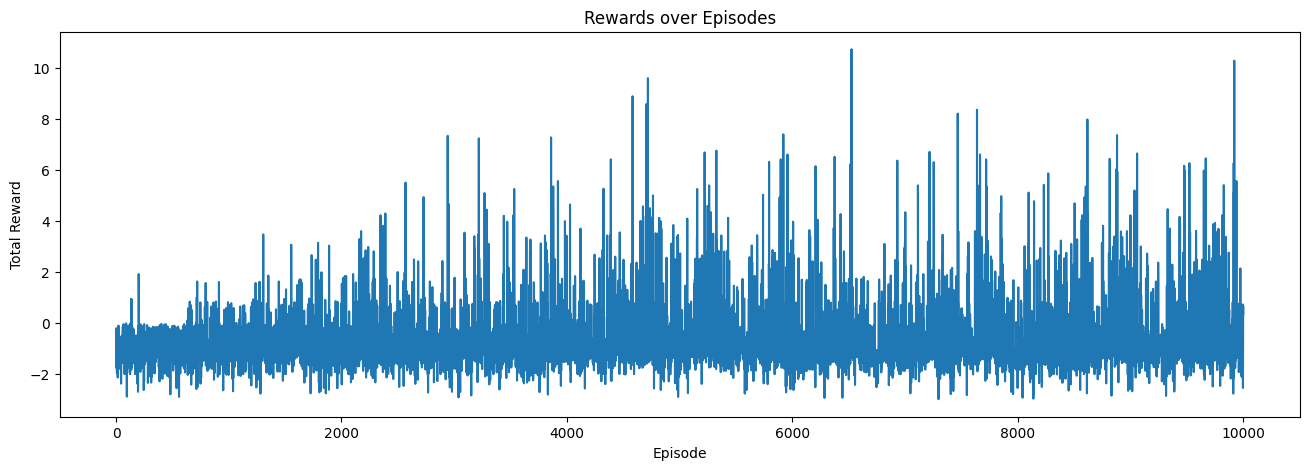

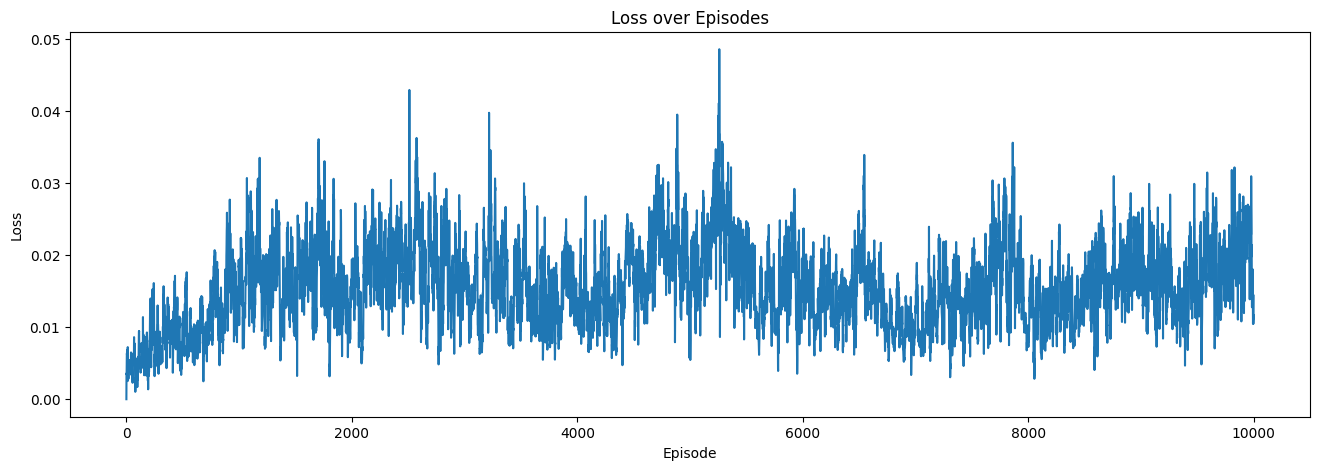

In [8]:

plt.figure(figsize=(16, 5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss over Episodes')
plt.show()


Inference

In [11]:
# Use neural net to watch the snake play

env = UnityEnvironment(file_name="unity_builds/snake", seed=1, side_channels=[], no_graphics=False)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
# n_observations = len(state)
n_observations = spec.observation_specs[0].shape[0]

# policy_net = DQN(n_observations, n_actions).to(device)
# policy_net = DuelingDQN(n_observations, n_actions).to(device)
# policy_net.load_state_dict(torch.load('weights/large_observations/4k/policy_net.pth'))
policy_net.load_state_dict(torch.load('weights/policy_net.pth'))
for t in range(5):
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for i in range(100):
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
    
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0

        if done or terminated:
            break
        state = torch.tensor(observation, dtype=torch.float32, device=device)
env.close()